<center>Минимстерство образования Республики Беларусь</center>

<center>Учреждение образования</center>

<center><<Брестский государственный технический университет>></center>

<center>Кафедра ИИТ</center>

<br /><br /><br /><br /><br /><br />

<center>Лабораторная работа №3</center>

<center>за 3 семестр</center>

<center>по дисциплине: "Методы и алгоритмы принятия решений"</center>

<center>Тема: "Нелинейные ИНС в задачах прогнозирования"</center>

<br /><br /><br /><br /><br /><br />

<div style="display: table; width: 100%;">
    <div style="float: right; width: 33%;">
        <p>Выполнил:</p>
        <p>студент 2 курса</p>
        <p>факультета ЭИС</p>
        <p>группы ПО-4(1)</p>
        <p>Галанин П. И.</p>
        <br />
        <p>Проверил:</p>
        <p>ст. преподаватель</p>
        <p>Крощенко А. А.</p>
    </div>
</div>

<br /><br /><br /><br /><br /><br />

<center>Брест 2020</center>

# Лабораторная работа №3

**Тема**: "Нелинейные ИНС в задачах прогнозирования".

**Цель работы**: "Изучить обучение и функционирование нелинейной ИНС при решении задач прогнозирования".

**Задание**:

1. Написать на любом ЯВУ программу моделирования прогнозирующей нелинейной ИНС. Для тестирования использовать функцию

Варианты заданий приведены в следующей таблице:

|№ варианта|a  |b  |с   |d  |Кол-во входов ИНС|Кол-во НЭ в скрытом слое|
|:--------:|:-:|:-:|:--:|:-:|:---------------:|:----------------------:|
|1         |0.1|0.1|0.05|0.1|6                |2                       |
|2         |0.2|0.2|0.06|0.2|8                |3                       |
|3         |0.3|0.3|0.07|0.3|10               |4                       |
|4         |0.4|0.4|0.08|0.4|6                |2                       |
|5         |0.1|0.5|0.09|0.5|8                |3                       |
|6         |0.2|0.6|0.05|0.6|10               |4                       |
|7         |0.3|0.1|0.06|0.1|6                |2                       |
|8         |0.4|0.2|0.07|0.2|8                |3                       |
|9         |0.1|0.3|0.08|0.3|10               |4                       |
|10        |0.2|0.4|0.09|0.4|6                |2                       |
|11        |0.3|0.5|0.05|0.5|8                |3                       |

Для прогнозирования использовать многослойную ИНС с одним скрытым слоем. В качестве функций активации для скрытого слоя использовать сигмоидную функцию, для выходного - линейную.

2. Результаты представить в виде отчета содержащего:
    1. Титульный лист
    2. Цель работы
    3. Задание
    4. График прогнозируемой функции на участке обучения
    5. Результаты обучения:
        - таблицу со столбцами:
            - эталонное значение
            - полученное значение
            - отклонение
        - график изменения ошибки в зависимости от итерации
    6. Результаты прогнозирования:
        - таблицу со столбцами:
            - эталонное значение
            - полученное значение
            - отклонение
    7. Выводы по лабораторной работе.
    
Результаты для пунктов 3 и 4 приводятся для значения $\alpha$, при котором достигается минимальная ошибка. В выводах анализируются все полученные результаты.

**Ход работы**:

Разработанная схема:

![](Scheme.png)

Использованные формулы:

Взвешенная сумма для скрытого слоя:

$S_i = e * w_{ki} - T_i$

Функция активации для скрытого слоя:

$y_i = sigm(S_i)$

Взвешенная сумма для выходного слоя:

$s_j = y_i * w_{ki} - T_j$

Функция активации для выходного слоя:

$y_j = linear(S_j)$

Ошибка нейронного элемента j-ого слоя:

$\gamma_j = y_j - e$

Ошибка нейронного элемента i-ого слоя:

$\gamma_i = \sum \gamma_j * F'(S_j) * w_{ij}$

Веса от скрытого слоя к выходному слою:

$\omega_{ij} = \omega_{ij} - \alpha * \gamma_j * F'(S_j) * y_i$

Пороги выходного слоя:

$T_j = T_j + \alpha * F'(S_j)$

Веса от входного слоя к скрытому слою:

$\omega_{ki} = \omega{ki} - \alpha * \gamma_i * F'(S_i) * y_i$

Пороги скрытого слоя:

$T_i = T_i + \alpha * \gamma_i * F(S_i)$

Средняя квадратичная ошибка сети:

$E = {1 \over 2} \sum(y_j - e)^2$

In [1]:
import numpy
from math import sin
from math import cos
import random
import matplotlib.pyplot

In [2]:
# Функция принимает параметры:
# m1 - number neurons for learning
# m2 - number neurons for test
# a - parametr for etalon function
# b - parametr for etalon function
# c - parametr for etalon function
# d - parametr for etalon function
# step - parametr for etalon function
# inputs - number neurons
# hiddens - number neurons
# outputs - number neurons
# Ee - desired squared error
# alpha_ki - learning rate (inputs - hiddens)
# alpha_ij - learning rate (hiddens - outputs)
def lab3(m1, m2, a, b, c, d, step, inputs, hiddens, outputs, Ee, alpha_ki, alpha_ij):
    # Функция возвращает массив с эталонными значениями
    def get_etalons(n):
        etalons = numpy.zeros(n)
        for i in range(len(etalons)):
            x = step * i
            y = a * cos(b * x) + c * sin(d * x)
            etalons[i] = y
        return etalons

    etalons = get_etalons(m1 + m2)
    #print(etalons)

    # Функция возвращает массив с весами
    # Например, 8 нейронов в входном слое и 3 в скрытом, тогда возвратит массив 8х3
    # Например, 3 нейрона в скрытом слое и 1 нейрон в выходном слое, тогда возвратит массив 3х1
    def get_weights(leftNumberNeurons, rightNumberNeurons, leftRandomBorder, rightRandomBorder):
        weights = numpy.zeros((leftNumberNeurons, rightNumberNeurons))
        for i in range(leftNumberNeurons):
            for j in range(rightNumberNeurons):
                weights[i][j] = random.uniform(leftRandomBorder, rightRandomBorder)
        return weights

    weights_ki = get_weights(inputs, hiddens, -1, 1)
    #print(weights_ki)

    weights_ij = get_weights(hiddens, outputs, -1, 1)
    #print(weights_ij)

    # Функция возвращает массив с порогами
    # Например, 8 нейронов в входном слое и 3 в скрытом, тогда возвратит массив размером 3
    # Например, 3 нейрона в скрытом слое и 1 нейрон в выходном слое, тогда возвратит массив размером 1
    def get_thresholds(numberNeurons, leftRandomBorder, rightRandomBorder):
        tresholds = numpy.zeros(numberNeurons)
        for i in range(numberNeurons):
            tresholds[i] = random.uniform(leftRandomBorder, rightRandomBorder)
        return tresholds

    tresholds_i = get_thresholds(hiddens, -1, 1)
    #print(tresholds_i)

    tresholds_j = get_thresholds(outputs, -1, 1)
    #print(tresholds_j)

    valuesXforGraph = []
    valuesYforGraph = []
    eras = 0
    while 1:
        for q in range(m1 - inputs):
            # Si = x * wki - Ti
            x = etalons[q:(q+inputs)]
            S_i = x.dot(weights_ki) - tresholds_i
            #print(S_i)
            # yi = Sigm(Si)
            y_i = numpy.zeros(len(S_i))
            for i in range(len(S_i)):
                y_i[i] = 1. / (1. + numpy.exp( - S_i[i] )) # sigmoid func
            #print(y_i)
            # Sj = yi * wij - Tj
            S_j = y_i.dot(weights_ij) - tresholds_j
            #print(S_j)
            # yj = Linear(Sj) = Sj
            y_j = S_j
            #print(y_j)
            # jj = yj - e
            j_j = numpy.array([ y_j[i] - etalons[q + inputs + i] for i in range(len(y_j)) ])
            #print(j_j)
            # ji = sum [dF(Sj) * wij]
            dF_j = 1
            j_i = numpy.zeros(hiddens)
            for i in range(hiddens):
                for j in range(outputs):
                    j_i[i] += j_j[j] * dF_j * weights_ij[i][j]
            #print(j_i)
            # wij = wij - alpha * jj * dFj * yi
            for i in range(hiddens):
                for j in range(outputs):
                    weights_ij[i][j] -= alpha_ij * j_j[j] * dF_j * y_j[j]
            #print(weights_ij)
            # Tj = Tj + alpha * jj * dFj
            for j in range(outputs):
                tresholds_j += alpha_ij * j_j[j] * dF_j
            #print(tresholds_j)
            # wki = wki - alpha * ji * dFi * yi
            for k in range(inputs):
                for i in range(hiddens):
                    dFi = y_i[i] * (1 - y_i[i]) # derivative sigmoid func
                    weights_ki[k][i] -= alpha_ki * j_i[i] * dFi * y_i[i]
            #print(weights_ki)
            # Ti = Ti + alpha * ji * dFi
            for i in range(hiddens):
                dFi = y_i[i] * (1 - y_i[i]) # derivative sigmoid func
                tresholds_i += alpha_ki * j_i[i] * dFi
            #print(tresholds_i)
        E = 0
        for j in range(outputs):
            E += 1./2 * (y_j[j] - etalons[q + inputs + j]) ** 2
        valuesXforGraph.append(E)
        eras += 1
        valuesYforGraph.append(eras)
        print('eras: %8d\tE: %32.20f\r' % (eras, E), end = '')
        if E < Ee:
            print()
            matplotlib.pyplot.plot(valuesYforGraph, valuesXforGraph, 'g-o')
            matplotlib.pyplot.title('E(eras)')
            break

    print('after learning:')
    for q in range(m1):
        # Si = x * wki - Ti
        x = etalons[q:(q+inputs)]
        S_i = x.dot(weights_ki) - tresholds_i
        #print(S_i)
        # yi = Sigm(Si)
        y_i = numpy.zeros(len(S_i))
        for i in range(len(S_i)):
            y_i[i] = 1. / (1. + numpy.exp( - S_i[i] )) # sigmoid func
        #print(y_i)
        # Sj = yi * wij - Tj
        S_j = y_i.dot(weights_ij) - tresholds_j
        #print(S_j)
        # yj = Linear(Sj) = Sj
        y_j = S_j
        print('%8d\t%24.20f\t%24.20f\t%24.20f' % (
            q,
            etalons[q + inputs],
            y_j,
            (etalons[q + inputs] - y_j) ** 2)
        )

    print('test:')
    for q in range(m2 - inputs):
        # Si = x * wki - Ti
        x = etalons[(q + m1):(q + inputs + m1)]
        S_i = x.dot(weights_ki) - tresholds_i
        #print(S_i)
        # yi = Sigm(Si)
        y_i = numpy.zeros(len(S_i))
        for i in range(len(S_i)):
            y_i[i] = 1. / (1. + numpy.exp( - S_i[i] )) # sigmoid func
        #print(y_i)
        # Sj = yi * wij - Tj
        S_j = y_i.dot(weights_ij) - tresholds_j
        #print(S_j)
        # yj = Linear(Sj) = Sj
        y_j = S_j
        print('%8d\t%24.20f\t%24.20f\t%24.20f' % (
            q + m1,
            etalons[q + m1 + inputs],
            y_j,
            (etalons[q + m1 + inputs] - y_j) ** 2)
        )

    print('Eras: %d' % eras)

    matplotlib.pyplot.show()

Тесты при разных $\alpha$:

eras:      266	E:           0.00000000872736413718
after learning:
       0	  0.10035919904106743727	  0.10148892167081938198	  0.00000127627322017365
       1	  0.10040398613483499102	  0.10148592240918291596	  0.00000117058610174987
       2	  0.10044874812760651306	  0.10148292547144130427	  0.00000106952277850118
       3	  0.10049348500819153818	  0.10147993085701992322	  0.00000097307541267075
       4	  0.10053819676540583228	  0.10147693856534452383	  0.00000088123616695213
       5	  0.10058288338807146178	  0.10147394859584127347	  0.00000079399720449786
       6	  0.10062754486501676587	  0.10147096094793667254	  0.00000071135068892796
       7	  0.10067218118507638425	  0.10146797562105766555	  0.00000063328878433877
       8	  0.10071679233709121548	  0.10146499261463157171	  0.00000055980365531147
       9	  0.10076137830990850031	  0.10146201192808607106	  0.00000049088746692059
      10	  0.10080593909238171058	  0.10145903356084930158	  0.00000042653238474297
      11	

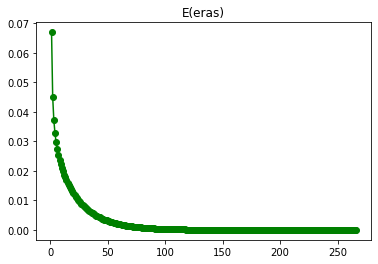

In [3]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    1,      # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      265	E:           0.00000000909379976081
after learning:
       0	  0.10035919904106743727	  0.10149870106732698793	  0.00000129846486784962
       1	  0.10040398613483499102	  0.10149536412107319772	  0.00000119110590884536
       2	  0.10044874812760651306	  0.10149202975650505054	  0.00000108843655719719
       3	  0.10049348500819153818	  0.10148869797299224504	  0.00000099044884530741
       4	  0.10053819676540583228	  0.10148536876990493782	  0.00000089713480610685
       5	  0.10058288338807146178	  0.10148204214661367406	  0.00000080848647306317
       6	  0.10062754486501676587	  0.10147871810248944302	  0.00000072449588018972
       7	  0.10067218118507638425	  0.10147539663690365030	  0.00000064515506205408
       8	  0.10071679233709121548	  0.10147207774922813173	  0.00000057045605378683
       9	  0.10076137830990850031	  0.10146876143883512555	  0.00000050039089109002
      10	  0.10080593909238171058	  0.10146544770509734190	  0.00000043495161024610
      11	

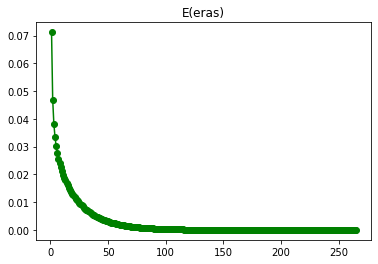

In [4]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.9,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      264	E:           0.00000000910262020096
after learning:
       0	  0.10035919904106743727	  0.10150765445058149150	  0.00000131894982764209
       1	  0.10040398613483499102	  0.10150389100755784211	  0.00000120979072903947
       2	  0.10044874812760651306	  0.10150013047102084129	  0.00000110540483204340
       3	  0.10049348500819153818	  0.10149637284027165918	  0.00000100578400373436
       4	  0.10053819676540583228	  0.10149261811461197935	  0.00000091092011182048
       5	  0.10058288338807146178	  0.10148886629334388787	  0.00000082080502464587
       6	  0.10062754486501676587	  0.10148511737577001202	  0.00000073543061119963
       7	  0.10067218118507638425	  0.10148137136119336765	  0.00000065478874112423
       8	  0.10071679233709121548	  0.10147762824891748412	  0.00000057887128472451
       9	  0.10076137830990850031	  0.10147388803824634873	  0.00000050767011297607
      10	  0.10080593909238171058	  0.10147015072848440675	  0.00000044117709753422
      11	

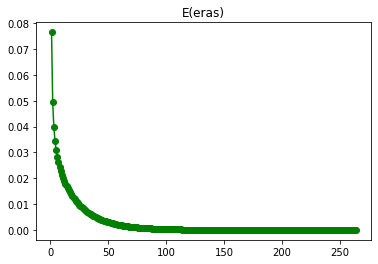

In [5]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.8,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      263	E:           0.00000000859453883697
after learning:
       0	  0.10035919904106743727	  0.10151539692195618581	  0.00000133679353977163
       1	  0.10040398613483499102	  0.10151107886524418644	  0.00000122565431372489
       2	  0.10044874812760651306	  0.10150676413607533088	  0.00000111939787417629
       3	  0.10049348500819153818	  0.10150245273366467758	  0.00000101801587104644
       4	  0.10053819676540583228	  0.10149814465722782619	  0.00000092149995501349
       5	  0.10058288338807146178	  0.10149383990598087601	  0.00000082984177752164
       6	  0.10062754486501676587	  0.10148953847914042592	  0.00000074303299078997
       7	  0.10067218118507638425	  0.10148524037592364377	  0.00000066106524782120
       8	  0.10071679233709121548	  0.10148094559554814154	  0.00000058393020241034
       9	  0.10076137830990850031	  0.10147665413723211403	  0.00000051161950915348
      10	  0.10080593909238171058	  0.10147236600019420016	  0.00000044412482345652
      11	

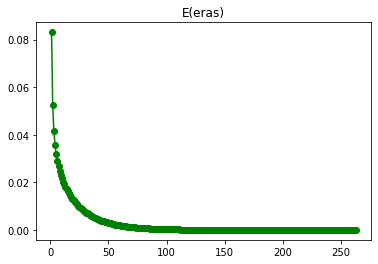

In [6]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.7,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      261	E:           0.00000000924600520820
after learning:
       0	  0.10035919904106743727	  0.10153587549602810514	  0.00000138456747965880
       1	  0.10040398613483499102	  0.10153080865254240917	  0.00000126972898641248
       2	  0.10044874812760651306	  0.10152574570273585619	  0.00000115992377683449
       3	  0.10049348500819153818	  0.10152068664571264889	  0.00000105514320412605
       4	  0.10053819676540583228	  0.10151563148057757280	  0.00000095537862242286
       5	  0.10058288338807146178	  0.10151058020643596858	  0.00000086062138680363
       6	  0.10062754486501676587	  0.10150553282239377362	  0.00000077086285329905
       7	  0.10067218118507638425	  0.10150048932755748043	  0.00000068609437890048
       8	  0.10071679233709121548	  0.10149544972103419216	  0.00000060630732156892
       9	  0.10076137830990850031	  0.10149041400193155316	  0.00000053149304024353
      10	  0.10080593909238171058	  0.10148538216935781842	  0.00000046164289485076
      11	

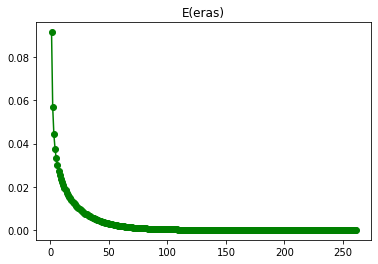

In [7]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.6,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      259	E:           0.00000000866639720917
after learning:
       0	  0.10035919904106743727	  0.10155367318825755940	  0.00000142676848830557
       1	  0.10040398613483499102	  0.10154754479558261715	  0.00000130772641057090
       2	  0.10044874812760651306	  0.10154142109463920596	  0.00000119393421288403
       3	  0.10049348500819153818	  0.10153530208438507620	  0.00000108538282024845
       4	  0.10053819676540583228	  0.10152918776377861665	  0.00000098206315885589
       5	  0.10058288338807146178	  0.10152307813177885443	  0.00000088396615609501
       6	  0.10062754486501676587	  0.10151697318734549669	  0.00000079108274056050
       7	  0.10067218118507638425	  0.10151087292943888896	  0.00000070340384206182
       8	  0.10071679233709121548	  0.10150477735702001514	  0.00000062092039163219
       9	  0.10076137830990850031	  0.10149868646905053915	  0.00000054362332153742
      10	  0.10080593909238171058	  0.10149260026449279104	  0.00000047150356528496
      11	

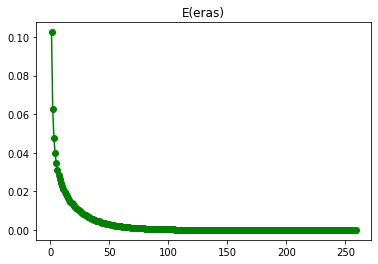

In [8]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.5,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      255	E:           0.00000000999730961129
after learning:
       0	  0.10035919904106743727	  0.10159697161343812788	  0.00000153208094091316
       1	  0.10040398613483499102	  0.10158923307708384032	  0.00000140481031411025
       2	  0.10044874812760651306	  0.10158150043289382314	  0.00000128312778513372
       3	  0.10049348500819153818	  0.10157377367962787396	  0.00000116702361363368
       4	  0.10053819676540583228	  0.10156605281604648428	  0.00000105648806083860
       5	  0.10058288338807146178	  0.10155833784091089500	  0.00000095151138956428
       6	  0.10062754486501676587	  0.10155062875298311031	  0.00000085208386422306
       7	  0.10067218118507638425	  0.10154292555102582829	  0.00000075819575083270
       8	  0.10071679233709121548	  0.10153522823380252416	  0.00000066983731702564
       9	  0.10076137830990850031	  0.10152753680007742254	  0.00000058699883205792
      10	  0.10080593909238171058	  0.10151985124861545584	  0.00000050967056681832
      11	

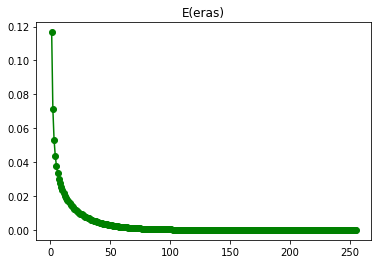

In [9]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.4,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      250	E:           0.00000000903365189437
after learning:
       0	  0.10035919904106743727	  0.10164604377760561027	  0.00000165596937595600
       1	  0.10040398613483499102	  0.10163561622473277213	  0.00000151691267834162
       2	  0.10044874812760651306	  0.10162519654218550580	  0.00000138403087216543
       3	  0.10049348500819153818	  0.10161478472845880683	  0.00000125731306267145
       4	  0.10053819676540583228	  0.10160438078204850343	  0.00000113674835734430
       5	  0.10058288338807146178	  0.10159398470145118709	  0.00000102232586591821
       6	  0.10062754486501676587	  0.10158359648516426810	  0.00000091403470038666
       7	  0.10067218118507638425	  0.10157321613168601715	  0.00000081186397501182
       8	  0.10071679233709121548	  0.10156284363951538496	  0.00000071580280633363
       9	  0.10076137830990850031	  0.10155247900715225207	  0.00000062584031317955
      10	  0.10080593909238171058	  0.10154212223309723451	  0.00000054196561667377
      11	

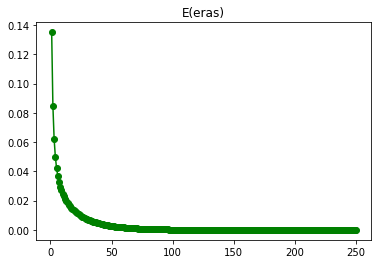

In [10]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.3,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      240	E:           0.00000000830304109675
after learning:
       0	  0.10035919904106743727	  0.10174878242711199450	  0.00000193094198677106
       1	  0.10040398613483499102	  0.10173316113491664980	  0.00000176670618084208
       2	  0.10044874812760651306	  0.10171755143877789229	  0.00000160986184243946
       3	  0.10049348500819153818	  0.10170195333692157169	  0.00000146039570154356
       4	  0.10053819676540583228	  0.10168636682757417611	  0.00000131829449165966
       5	  0.10058288338807146178	  0.10167079190896279040	  0.00000118354494982796
       6	  0.10062754486501676587	  0.10165522857931515166	  0.00000105613381663413
       7	  0.10067218118507638425	  0.10163967683685956600	  0.00000093604783621936
       8	  0.10071679233709121548	  0.10162413667982497789	  0.00000082327375629096
       9	  0.10076137830990850031	  0.10160860810644097019	  0.00000071779832813245
      10	  0.10080593909238171058	  0.10159309111493776412	  0.00000061960830661409
      11	

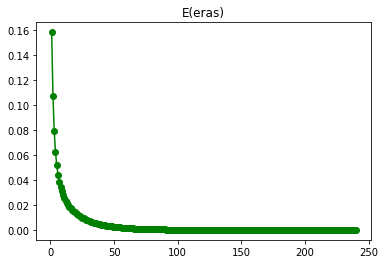

In [11]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.2,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      215	E:           0.00000000794724147772
after learning:
       0	  0.10035919904106743727	  0.10200230304048184260	  0.00000269979075289161
       1	  0.10040398613483499102	  0.10197439400776786567	  0.00000246618088736956
       2	  0.10044874812760651306	  0.10194650476395621108	  0.00000224327494172956
       3	  0.10049348500819153818	  0.10191863530819383898	  0.00000203105337759665
       4	  0.10053819676540583228	  0.10189078563962597479	  0.00000182949666266411
       5	  0.10058288338807146178	  0.10186295575739620634	  0.00000163858527070867
       6	  0.10062754486501676587	  0.10183514566064642837	  0.00000145829968160539
       7	  0.10067218118507638425	  0.10180735534851673152	  0.00000128862038134249
       8	  0.10071679233709121548	  0.10177958482014567987	  0.00000112952786203707
       9	  0.10076137830990850031	  0.10175183407467008889	  0.00000098100262194946
      10	  0.10080593909238171058	  0.10172410311122515036	  0.00000084302516549874
      11	

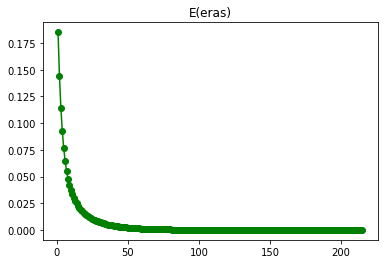

In [12]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.1,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      211	E:           0.00000000715286000311
after learning:
       0	  0.10035919904106743727	  0.10203718124631594444	  0.00000281562428113064
       1	  0.10040398613483499102	  0.10200729164553720696	  0.00000257058856064809
       2	  0.10044874812760651306	  0.10197742303064197267	  0.00000233684695917047
       3	  0.10049348500819153818	  0.10194757540121270056	  0.00000211437887107644
       4	  0.10053819676540583228	  0.10191774875682957369	  0.00000190316369704121
       5	  0.10058288338807146178	  0.10188794309707038810	  0.00000170318084405236
       6	  0.10062754486501676587	  0.10185815842151066390	  0.00000151440972542656
       7	  0.10067218118507638425	  0.10182839472972346484	  0.00000133682976082537
       8	  0.10071679233709121548	  0.10179865202127974522	  0.00000117042037627251
       9	  0.10076137830990850031	  0.10176893029574793359	  0.00000101516100416899
      10	  0.10080593909238171058	  0.10173922955269426582	  0.00000087103108331042
      11	

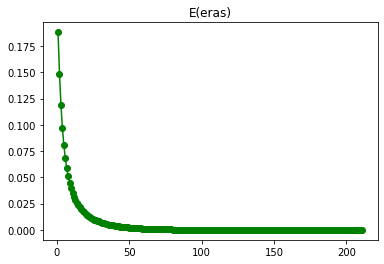

In [13]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.09,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      206	E:           0.00000000799493406806
after learning:
       0	  0.10035919904106743727	  0.10208839988459120218	  0.00000299013555724330
       1	  0.10040398613483499102	  0.10205638444305212276	  0.00000273042016899884
       2	  0.10044874812760651306	  0.10202439120807207940	  0.00000248265111701902
       3	  0.10049348500819153818	  0.10199242017983822794	  0.00000224680664879949
       4	  0.10053819676540583228	  0.10196047135853476828	  0.00000202286501826008
       5	  0.10058288338807146178	  0.10192854474434270839	  0.00000181080448576177
       6	  0.10062754486501676587	  0.10189664033743991989	  0.00000161060331812495
       7	  0.10067218118507638425	  0.10186475813800116574	  0.00000142223978864736
       8	  0.10071679233709121548	  0.10183289814619814195	  0.00000124569217712223
       9	  0.10076137830990850031	  0.10180106036219940813	  0.00000108093876985583
      10	  0.10080593909238171058	  0.10176924478617040137	  0.00000092795785968571
      11	

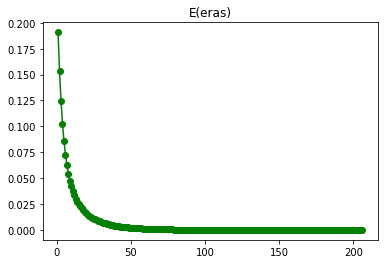

In [14]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.08,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      201	E:           0.00000000765540771079
after learning:
       0	  0.10035919904106743727	  0.10213192040646416892	  0.00000314254103933405
       1	  0.10040398613483499102	  0.10209769150835235063	  0.00000286863789228158
       2	  0.10044874812760651306	  0.10206348598932879490	  0.00000260737836207945
       3	  0.10049348500819153818	  0.10202930385041300565	  0.00000235873951612249
       4	  0.10053819676540583228	  0.10199514509262042061	  0.00000212269842817339
       5	  0.10058288338807146178	  0.10196100971696246684	  0.00000189923217838260
       6	  0.10062754486501676587	  0.10192689772444646357	  0.00000168831785330813
       7	  0.10067218118507638425	  0.10189280911607576097	  0.00000148993254593582
       8	  0.10071679233709121548	  0.10185874389284957364	  0.00000130405335569893
       9	  0.10076137830990850031	  0.10182470205576313327	  0.00000113065738849833
      10	  0.10080593909238171058	  0.10179068360580759145	  0.00000096972175672237
      11	

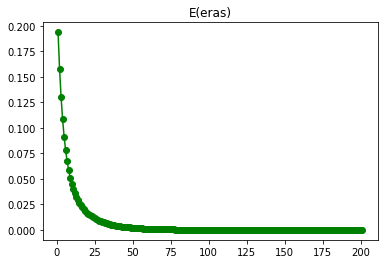

In [15]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.07,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      196	E:           0.00000000651279067329
after learning:
       0	  0.10035919904106743727	  0.10216750002826525956	  0.00000326995246030062
       1	  0.10040398613483499102	  0.10213110981414320888	  0.00000298295620362716
       2	  0.10044874812760651306	  0.10209474396487321080	  0.00000270930229629930
       3	  0.10049348500819153818	  0.10205840248260192316	  0.00000244896670171498
       4	  0.10053819676540583228	  0.10202208536947063311	  0.00000220192538927338
       5	  0.10058288338807146178	  0.10198579262761577058	  0.00000196815433439879
       6	  0.10062754486501676587	  0.10194952425916839478	  0.00000174762951856151
       7	  0.10067218118507638425	  0.10191328026625466607	  0.00000154032692930158
       8	  0.10071679233709121548	  0.10187706065099558228	  0.00000134622256025048
       9	  0.10076137830990850031	  0.10184086541550711746	  0.00000116529241115368
      10	  0.10080593909238171058	  0.10180469456190008315	  0.00000099751248789286
      11	

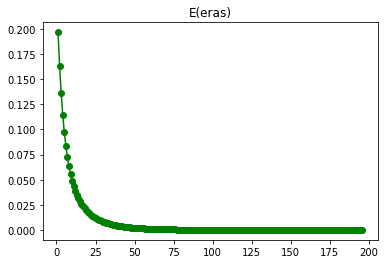

In [16]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.06,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      190	E:           0.00000000932487490592
after learning:
       0	  0.10035919904106743727	  0.10222749372566392045	  0.00000349052502849147
       1	  0.10040398613483499102	  0.10218930784487367802	  0.00000318737360833546
       2	  0.10044874812760651306	  0.10215114686683371414	  0.00000289816146732236
       3	  0.10049348500819153818	  0.10211301079516257873	  0.00000262286377466417
       4	  0.10053819676540583228	  0.10207489963347265993	  0.00000236145570472481
       5	  0.10058288338807146178	  0.10203681338537008705	  0.00000211391243704478
       6	  0.10062754486501676587	  0.10199875205445502191	  0.00000188020915636716
       7	  0.10067218118507638425	  0.10196071564432125645	  0.00000166032105266148
       8	  0.10071679233709121548	  0.10192270415855669841	  0.00000145422332115020
       9	  0.10076137830990850031	  0.10188471760074294115	  0.00000126189116233242
      10	  0.10080593909238171058	  0.10184675597445545792	  0.00000108329978200972
      11	

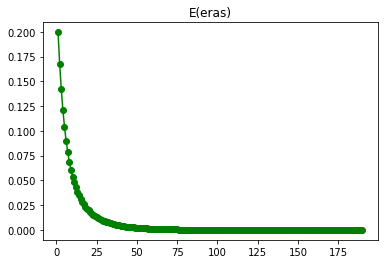

In [17]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.05,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      186	E:           0.00000000875365931337
after learning:
       0	  0.10035919904106743727	  0.10223912626782211133	  0.00000353412637789352
       1	  0.10040398613483499102	  0.10220018783983698951	  0.00000322634056505209
       2	  0.10044874812760651306	  0.10216127393001495083	  0.00000293274462391466
       3	  0.10049348500819153818	  0.10212238454373148699	  0.00000265331369688226
       4	  0.10053819676540583228	  0.10208351968635509532	  0.00000238802293001116
       5	  0.10058288338807146178	  0.10204467936324758404	  0.00000213684747304111
       6	  0.10062754486501676587	  0.10200586357976376695	  0.00000189976247942182
       7	  0.10067218118507638425	  0.10196707234125157449	  0.00000167674310634072
       8	  0.10071679233709121548	  0.10192830565305215085	  0.00000146776451475066
       9	  0.10076137830990850031	  0.10188956352049959031	  0.00000127280186939646
      10	  0.10080593909238171058	  0.10185084594892124255	  0.00000109183033884333
      11	

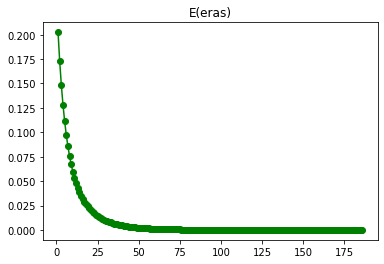

In [18]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.04,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      185	E:           0.00000000823922883566
after learning:
       0	  0.10035919904106743727	  0.10219952678444949035	  0.00000338680620306168
       1	  0.10040398613483499102	  0.10216230731597356063	  0.00000309169337604053
       2	  0.10044874812760651306	  0.10212511023743423011	  0.00000281018992326604
       3	  0.10049348500819153818	  0.10208793555582423851	  0.00000254227254884622
       4	  0.10053819676540583228	  0.10205078327812938666	  0.00000228791795847320
       5	  0.10058288338807146178	  0.10201365341132886955	  0.00000204710285945200
       6	  0.10062754486501676587	  0.10197654596239494329	  0.00000181980396072753
       7	  0.10067218118507638425	  0.10193946093829325816	  0.00000160599797291342
       8	  0.10071679233709121548	  0.10190239834598260882	  0.00000140566160831938
       9	  0.10076137830990850031	  0.10186535819241510081	  0.00000121877158097929
      10	  0.10080593909238171058	  0.10182834048453605347	  0.00000104530460667914
      11	

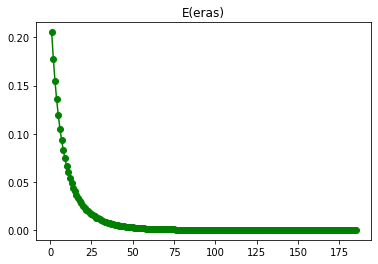

In [19]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.03,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      191	E:           0.00000000842154079053
after learning:
       0	  0.10035919904106743727	  0.10205603865671969421	  0.00000287926468124690
       1	  0.10040398613483499102	  0.10202577017939334914	  0.00000263018348718407
       2	  0.10044874812760651306	  0.10199551898702932662	  0.00000239250009155959
       3	  0.10049348500819153818	  0.10196528508678739944	  0.00000216619547135478
       4	  0.10053819676540583228	  0.10193506848582239988	  0.00000195125060329954
       5	  0.10058288338807146178	  0.10190486919128365073	  0.00000174764646389458
       6	  0.10062754486501676587	  0.10187468721031586738	  0.00000155536402943814
       7	  0.10067218118507638425	  0.10184452255005826959	  0.00000137438427604759
       8	  0.10071679233709121548	  0.10181437521764512277	  0.00000120468817968501
       9	  0.10076137830990850031	  0.10178424522020565468	  0.00000104625671618085
      10	  0.10080593909238171058	  0.10175413256486381952	  0.00000089907086125768
      11	

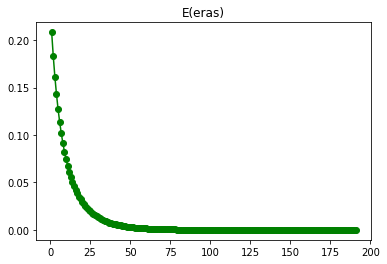

In [20]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.02,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      211	E:           0.00000000950137269108
after learning:
       0	  0.10035919904106743727	  0.10173284197204061907	  0.00000188689490181259
       1	  0.10040398613483499102	  0.10171844135764299133	  0.00000172779253276723
       2	  0.10044874812760651306	  0.10170404872345140124	  0.00000157577958592853
       3	  0.10049348500819153818	  0.10168966407319601775	  0.00000143084435555499
       4	  0.10053819676540583228	  0.10167528741060449793	  0.00000129297513539832
       5	  0.10058288338807146178	  0.10166091873940258372	  0.00000116216021871962
       6	  0.10062754486501676587	  0.10164655806331401866	  0.00000103838789830400
       7	  0.10067218118507638425	  0.10163220538606025645	  0.00000092164646647472
       8	  0.10071679233709121548	  0.10161786071136068299	  0.00000081192421510862
       9	  0.10076137830990850031	  0.10160352404293271356	  0.00000070920943565089
      10	  0.10080593909238171058	  0.10158919538449137643	  0.00000061349041912938
      11	

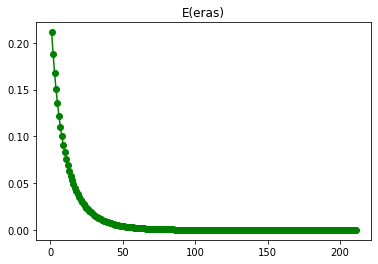

In [21]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.01,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      214	E:           0.00000000969902986252
after learning:
       0	  0.10035919904106743727	  0.10168979384444926106	  0.00000177048253078671
       1	  0.10040398613483499102	  0.10167752284827973053	  0.00000162189576049163
       2	  0.10044874812760651306	  0.10166525865754003077	  0.00000147989786943913
       3	  0.10049348500819153818	  0.10165300127539565744	  0.00000134447797391097
       4	  0.10053819676540583228	  0.10164075070501024656	  0.00000121562518973721
       5	  0.10058288338807146178	  0.10162850694954585207	  0.00000109332863231039
       6	  0.10062754486501676587	  0.10161627001216247401	  0.00000097757741659830
       7	  0.10067218118507638425	  0.10160403989601848873	  0.00000086836065715868
       8	  0.10071679233709121548	  0.10159181660427052396	  0.00000076566746815269
       9	  0.10076137830990850031	  0.10157960014007327842	  0.00000066948696335820
      10	  0.10080593909238171058	  0.10156739050657986878	  0.00000057980825618438
      11	

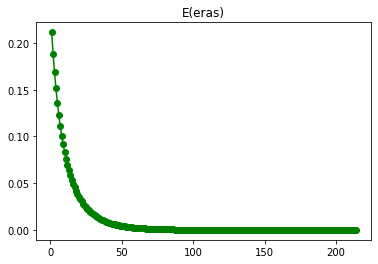

In [22]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.009,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      218	E:           0.00000000772919111843
after learning:
       0	  0.10035919904106743727	  0.10162871554630290016	  0.00000161167215706526
       1	  0.10040398613483499102	  0.10161865456374302719	  0.00000147541939218592
       2	  0.10044874812760651306	  0.10160859917189360435	  0.00000134525444493386
       3	  0.10049348500819153818	  0.10159854937333001601	  0.00000122116725109891
       4	  0.10053819676540583228	  0.10158850517062648078	  0.00000110314774607714
       5	  0.10058288338807146178	  0.10157846656635505234	  0.00000099118586488126
       6	  0.10062754486501676587	  0.10156843356308721538	  0.00000088527154215671
       7	  0.10067218118507638425	  0.10155840616339226190	  0.00000078539471219098
       8	  0.10071679233709121548	  0.10154838436983845695	  0.00000069154530892869
       9	  0.10076137830990850031	  0.10153836818499248351	  0.00000060371326598302
      10	  0.10080593909238171058	  0.10152835761141973392	  0.00000052188851664909
      11	

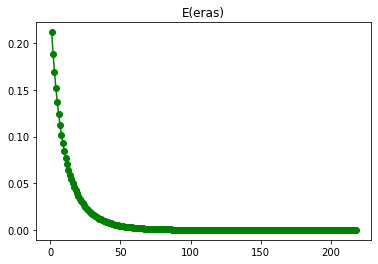

In [23]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.008,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      221	E:           0.00000000888268119917
after learning:
       0	  0.10035919904106743727	  0.10158999325182385687	  0.00000151485438923152
       1	  0.10040398613483499102	  0.10158221472624498483	  0.00000138822261361598
       2	  0.10044874812760651306	  0.10157444053791767069	  0.00000126718340263214
       3	  0.10049348500819153818	  0.10156667068880878557	  0.00000115172750508190
       4	  0.10053819676540583228	  0.10155890518088367402	  0.00000104184566942729
       5	  0.10058288338807146178	  0.10155114401610712549	  0.00000093752864380402
       6	  0.10062754486501676587	  0.10154338719644223632	  0.00000083876717603084
       7	  0.10067218118507638425	  0.10153563472385127020	  0.00000074555201362287
       8	  0.10071679233709121548	  0.10152788660029540835	  0.00000065787390380275
       9	  0.10076137830990850031	  0.10152014282773483278	  0.00000057572359351223
      10	  0.10080593909238171058	  0.10151240340812814344	  0.00000049909182942308
      11	

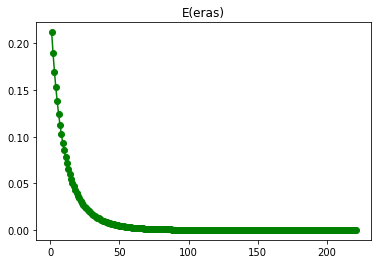

In [24]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.007,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      225	E:           0.00000000798710792967
after learning:
       0	  0.10035919904106743727	  0.10153419004966940387	  0.00000138060387029547
       1	  0.10040398613483499102	  0.10152875379669309974	  0.00000126510229316176
       2	  0.10044874812760651306	  0.10152332059206314874	  0.00000115470598136841
       3	  0.10049348500819153818	  0.10151789043712783345	  0.00000104940648283416
       4	  0.10053819676540583228	  0.10151246333323468707	  0.00000094919534518902
       5	  0.10058288338807146178	  0.10150703928173032686	  0.00000085406411578442
       6	  0.10062754486501676587	  0.10150161828396075947	  0.00000076400434170444
       7	  0.10067218118507638425	  0.10149620034127099233	  0.00000067900756977567
       8	  0.10071679233709121548	  0.10149078545500528348	  0.00000059906534657834
       9	  0.10076137830990850031	  0.10148537362650753013	  0.00000052416921845733
      10	  0.10080593909238171058	  0.10147996485712024173	  0.00000045431073153136
      11	

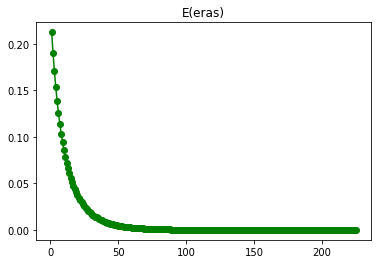

In [25]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.006,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      228	E:           0.00000000984378012982
after learning:
       0	  0.10035919904106743727	  0.10149816599144825813	  0.00000129724571405979
       1	  0.10040398613483499102	  0.10149512069621741128	  0.00000119057463104321
       2	  0.10044874812760651306	  0.10149207712708546714	  0.00000108853540115376
       3	  0.10049348500819153818	  0.10148903528478131486	  0.00000099112035321798
       4	  0.10053819676540583228	  0.10148599517003334403	  0.00000089832181581446
       5	  0.10058288338807146178	  0.10148295678356988869	  0.00000081013211728407
       6	  0.10062754486501676587	  0.10147992012611836699	  0.00000072654358573802
       7	  0.10067218118507638425	  0.10147688519840608601	  0.00000064754854906893
       8	  0.10071679233709121548	  0.10147385200115971449	  0.00000057313933495951
       9	  0.10076137830990850031	  0.10147082053510547706	  0.00000050330827089244
      10	  0.10080593909238171058	  0.10146779080096951509	  0.00000043804768416060
      11	

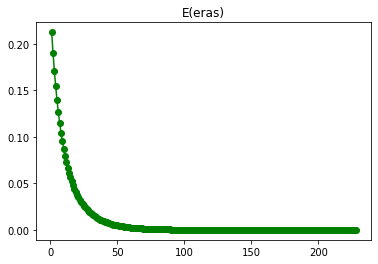

In [26]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.005,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      232	E:           0.00000000961968105404
after learning:
       0	  0.10035919904106743727	  0.10144591555253612558	  0.00000118095277629868
       1	  0.10040398613483499102	  0.10144529562989809679	  0.00000108432546450858
       2	  0.10044874812760651306	  0.10144467608140209092	  0.00000099187248915145
       3	  0.10049348500819153818	  0.10144405690716695734	  0.00000090358693512173
       4	  0.10053819676540583228	  0.10144343810731140665	  0.00000081946188709500
       5	  0.10058288338807146178	  0.10144281968195426047	  0.00000073949042953688
       6	  0.10062754486501676587	  0.10144220163121386857	  0.00000066366564671072
       7	  0.10067218118507638425	  0.10144158395520877503	  0.00000059198062268740
       8	  0.10071679233709121548	  0.10144096665405738511	  0.00000052442844135342
       9	  0.10076137830990850031	  0.10144034972787790982	  0.00000046100218641939
      10	  0.10080593909238171058	  0.10143973317678864343	  0.00000040169494142922
      11	

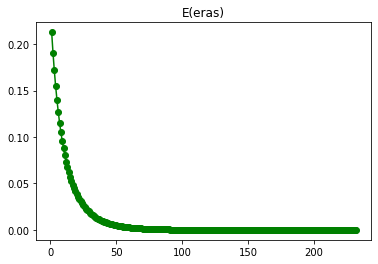

In [27]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.004,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      236	E:           0.00000000969918181598
after learning:
       0	  0.10035919904106743727	  0.10139539926729401742	  0.00000107371090883202
       1	  0.10040398613483499102	  0.10139722600367720440	  0.00000098652543705770
       2	  0.10044874812760651306	  0.10139905173551930218	  0.00000090307694721206
       3	  0.10049348500819153818	  0.10140087646234804963	  0.00000082335925107627
       4	  0.10053819676540583228	  0.10140270018369115790	  0.00000074736616022701
       5	  0.10058288338807146178	  0.10140452289907717076	  0.00000067509148604570
       6	  0.10062754486501676587	  0.10140634460803418793	  0.00000060652903972400
       7	  0.10067218118507638425	  0.10140816531009108625	  0.00000054167263227366
       8	  0.10071679233709121548	  0.10140998500477690913	  0.00000048051607453321
       9	  0.10076137830990850031	  0.10141180369162075547	  0.00000042305317717553
      10	  0.10080593909238171058	  0.10141362137015214051	  0.00000036927775071626
      11	

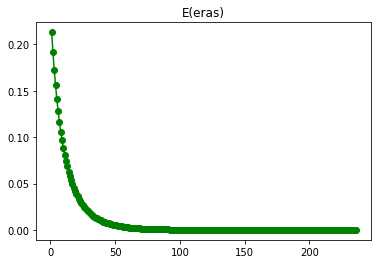

In [28]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.003,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      241	E:           0.00000000802131527509
after learning:
       0	  0.10035919904106743727	  0.10133155641702362715	  0.00000094547886657641
       1	  0.10040398613483499102	  0.10133583728326311935	  0.00000086834656282682
       2	  0.10044874812760651306	  0.10134011574310200499	  0.00000079453622595412
       3	  0.10049348500819153818	  0.10134439179550586152	  0.00000072404236069758
       4	  0.10053819676540583228	  0.10134866543944015538	  0.00000065685947159095
       5	  0.10058288338807146178	  0.10135293667387129668	  0.00000059298206297112
       6	  0.10062754486501676587	  0.10135720549776655597	  0.00000053240463898482
       7	  0.10067218118507638425	  0.10136147191009331481	  0.00000047512170359437
       8	  0.10071679233709121548	  0.10136573590982006499	  0.00000042112776058608
       9	  0.10076137830990850031	  0.10136999749591546482	  0.00000037041731357578
      10	  0.10080593909238171058	  0.10137425666734900531	  0.00000032298486601671
      11	

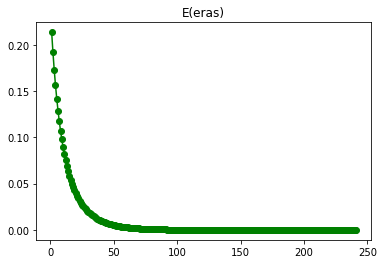

In [29]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.002,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)

eras:      245	E:           0.00000000854465060502
after learning:
       0	  0.10035919904106743727	  0.10128449268241776493	  0.00000085616832272335
       1	  0.10040398613483499102	  0.10129122242407004317	  0.00000078718823293559
       2	  0.10044874812760651306	  0.10129794833760030759	  0.00000072114099665350
       3	  0.10049348500819153818	  0.10130467042144888912	  0.00000065802177468150
       4	  0.10053819676540583228	  0.10131138867405711790	  0.00000059782572760382
       5	  0.10058288338807146178	  0.10131810309386712898	  0.00000054054801579027
       6	  0.10062754486501676587	  0.10132481367932225091	  0.00000048618379940298
       7	  0.10067218118507638425	  0.10133152042886686695	  0.00000043472823840221
       8	  0.10071679233709121548	  0.10133822334094597095	  0.00000038617649255193
       9	  0.10076137830990850031	  0.10134492241400577806	  0.00000034052372142669
      10	  0.10080593909238171058	  0.10135161764649344707	  0.00000029776508441748
      11	

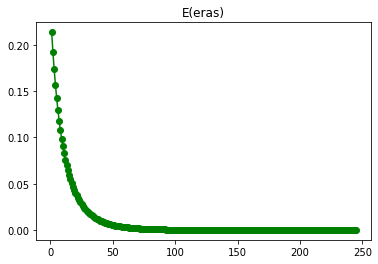

In [30]:
random.seed(2)
lab3(
    30,     # m1 - number neurons for learning
    40,     # m2 - number neurons for test
    0.1,    # a - parametr for etalon function
    0.5,    # b - parametr for etalon function
    0.09,   # c - parametr for etalon function
    0.5,    # d - parametr for etalon function
    0.001,  # step - parametr for etalon function
    8,      # inputs - number neurons
    3,      # hiddens - number neurons
    1,      # outputs - number neurons
    1e-8,   # Ee - desired squared error
    0.001,    # alpha_ki - learning rate (inputs - hiddens)
    0.001   # alpha_ij - learning rate (hiddens - outputs)
)